# E3 - basic ML
## 1. Retrieving sequences
The first step I used was the uniprot id mapping tool. By setting it from gene name to uniprotKB and restricting to Saccharomyces cerevisiae we can get the sequences of all the genes found in the uniprot database. I did this by searching for all the systematic names and gene names, since we can remove the duplicates later. We can download the sequences as a fasta file. The next step is to add our transcription rates to the headers. Note that not all genes were in the document were found in the UniProt database. Can you think of a different way to retrieve all of the sequences?


## 2: Formatting fasta file
With the previously made fasta file we need to remove the duplicates and rewrite the header to be gene_name|transcription_rate. For readability I have split this down into multiple functions. extract_gn() takes the gene name from the header in our unprocessed fasta file. get_tr() uses the gene name to lookup what the tr value is. remove_duplicates creates a new fasta file without duplicate entries and uses both get_tr() and extract_gn() to write the header in the format 'gene_name|tr'. The final line which uses remove_duplicates() to generate processed.fasta is commented out to prevent it from running every time this notebook is run. 

In [1]:
# change to split header and make dictionary for gene name. Append TR as entry in dictionary

import pandas as pd

def extract_gn(string):
    # Find the index of 'GN=' in the string
    gn_index = string.find('GN=')
    if gn_index != -1:  # If 'GN=' is found
        # Extract the substring starting from 'GN='
        gn_substr = string[gn_index:]
        # Split the substring by spaces and get the first part after 'GN='
        gn_value = gn_substr.split(' ')[0][3:]
        return gn_value
    else:
        return "no_gene_name"


def get_tr_value(csv_file, gene_name):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    
    # Look for the gene name in either 'Sistematic name' or 'gene name' column
    mask = (df['Sistematic name'] == gene_name) | (df['Gene name'] == gene_name)
    filtered_df = df[mask]
    
    # If any matching rows are found, return the TR (mol/min) dilution corrected
    if not filtered_df.empty:
        tr_value = filtered_df.iloc[0]['TR (mol/min) dilution corrected']
        return tr_value
    else:
        return None


def remove_duplicates(input_file, output_file):
    sequences = {}
    
    # Read the input FASTA file
    with open(input_file, 'r') as f:
        current_sequence = ''
        current_gene = ''
        for line in f:
            if line.startswith('>'):
                if current_sequence:
                    sequences[current_gene] = current_sequence
                    current_sequence = ''
                current_gene = extract_gn(line.strip())
            else:
                current_sequence += line.strip()
        # Add the last sequence
        sequences[current_gene] = current_sequence
    
    # Write unique sequences to the output FASTA file
    with open(output_file, 'w') as out:
        for header, sequence in sequences.items():
            if get_tr_value("yeast_gene_tr.csv", header) != None and str(get_tr_value("yeast_gene_tr.csv", header)) != "nan":
                out.write(">"+header + "|" + str(get_tr_value("yeast_gene_tr.csv", header)) + '\n')
                out.write(sequence + '\n')


input_file = 'unprocessed.fasta'
output_file = 'processed.fasta'
remove_duplicates(input_file, output_file)


/tmp/ipykernel_4901/3602387366.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 3. One-hot encoding protein data
To one-hot encode our sequences we need to parse through processed.fasta and extract sequences in a dataframe, where each row is a protein sequence and each column is a position in the sequence. Note that since all rows in a dataframe need to be the same length, this means that if a sequence has no amino acid at that position \(because the sequence is shorter than the number of columns\) we need to enter a value representing this. In this case we use 'na'. The result of parse_fasta() is then a dataframe with number of columns equal to the length of the longest sequence, number of rows equal to the number of sequences, and sequences padded by 'na' if they are shorter than the longest sequence.

In [2]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

def parse_fasta(file_path):
    sequences = []
    targets = []
    sequence = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith('>'):
                if sequence:
                    sequences.append(sequence)
                sequence = []
                targets.append(float(line.strip().split('|')[1]))
            else:
                for aa in line:
                    sequence.append(aa)
        sequences.append(sequence)
    max_length = max(len(protein) for protein in sequences)
    sequence_array = [protein + ['na'] * (max_length - len(protein)) for protein in sequences]
    sequence_array = np.array(sequence_array)
    return sequence_array, targets


sequences, targets = parse_fasta('processed.fasta')
enc = OneHotEncoder(handle_unknown='ignore')
one_hot_sequences = enc.fit_transform(sequences, targets)


## 4. Splitting data into training and testing subsets

In [3]:
from sklearn.model_selection import train_test_split

train_sequences, test_sequences, train_targets, test_targets = train_test_split(one_hot_sequences, targets, train_size=0.8, random_state=42)

## 5. Dimensionality reduction
To do dimensionality reduction with scikit learn we need to define the hyperparameters of our dimensionality reduction, and then fit the model to the data, and then transform the data with our model. In practice we can do this by defining the model and using the .fit_transform method.

In [4]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

pca = PCA(n_components=100, svd_solver='arpack')
pca_train_sequences = pca.fit_transform(train_sequences)

tsvd = TruncatedSVD(n_components=100, algorithm='arpack')
tsvd_train_sequences = tsvd.fit_transform(train_sequences)

tsne = TSNE(n_components=3, random_state=42)
tsne_train_sequences = tsne.fit_transform(tsvd_train_sequences)

We will then plot the results with matplotlib. We will make a scatterplot with an axis for the first and second components of our dimensionality reduction, and colour points by their tr. Ideally what we want to see is points of similar colour clustered together in groups. In this example we can see that we have no visible clustering from any of the methods used. It is, however, a good example of how differently various dimensionality reduction techniques can transform data, each giving completely different representations of the data.

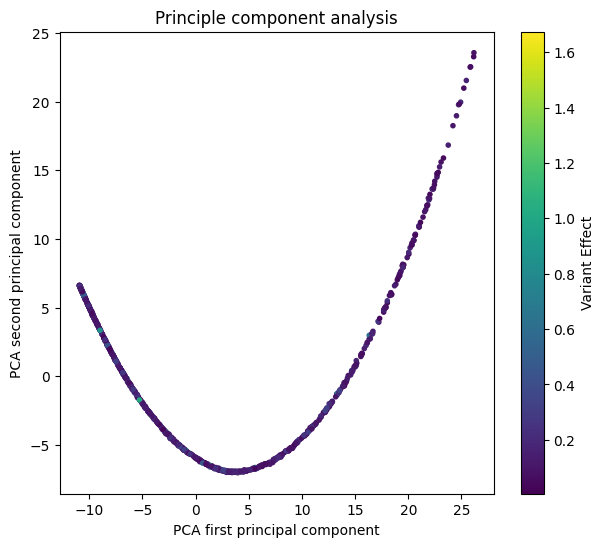

In [5]:
# Plotting PCA results
import matplotlib.pyplot as plt

fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(pca_train_sequences[:,0], pca_train_sequences[:,1], c=train_targets, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
ax.set_title('Principle component analysis')
plt.colorbar(sc, label='Variant Effect')

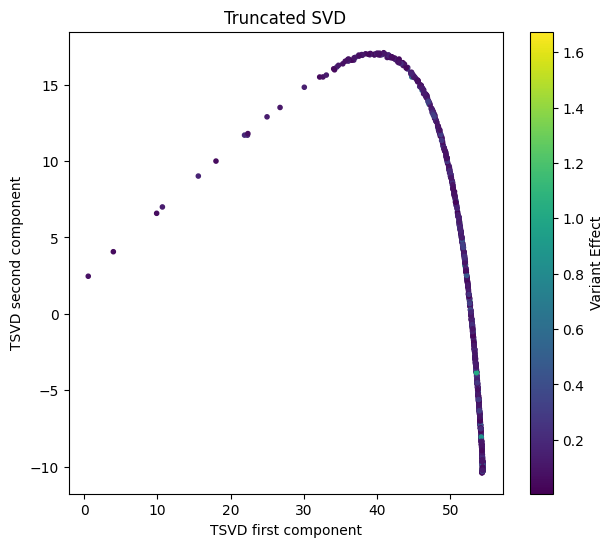

In [6]:
# Plotting TSVD results
fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(tsvd_train_sequences[:,0], tsvd_train_sequences[:,1], c=train_targets, marker='.')
ax.set_xlabel('TSVD first component')
ax.set_ylabel('TSVD second component')
ax.set_title('Truncated SVD')
plt.colorbar(sc, label='Variant Effect')

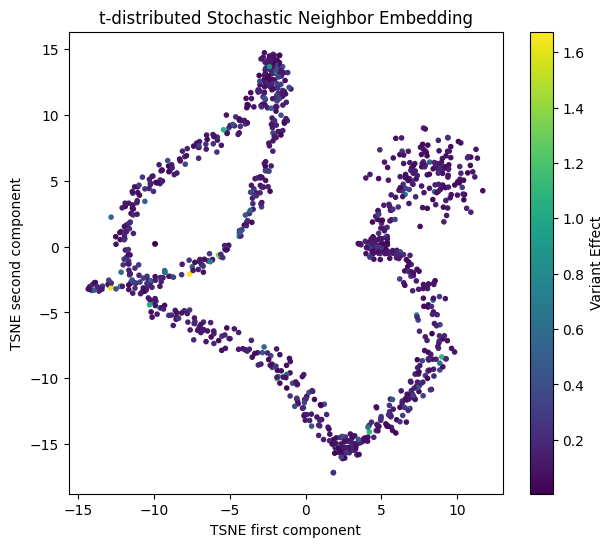

In [7]:
# Plotting TSNE results
fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(tsne_train_sequences[:,0], tsne_train_sequences[:,1], c=train_targets, marker='.')
ax.set_xlabel('TSNE first component')
ax.set_ylabel('TSNE second component')
ax.set_title('t-distributed Stochastic Neighbor Embedding')
plt.colorbar(sc, label='Variant Effect')

## 6. Training and testing knn model
We will use sklearn's KNeighboursRegressor. Similarly to the dimensionality reduction methods we need to define the hyperparameters and then fit it to our training data. We can then test it with our testing data by using the score method and the mean_squared error function. You can do this with all dimensionality reduction methods, although I will only test with our pca reduced data. 

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# We need to also do PCA on the test data using the same model as the training data
pca_test_sequences = pca.transform(test_sequences)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(pca_train_sequences, train_targets)
r_squared = knn.score(pca_test_sequences, test_targets)
mean_sqr_err = mean_squared_error(test_targets, knn.predict(pca_test_sequences))

print(f'R^2: {r_squared} \nMean squared error: {mean_sqr_err}')

R^2: -0.26150397955142535 
Mean squared error: 0.029264519581679388


As we can see our model performed poorly. In fact, so poorly that we would be better off always guessing the expected value of the tr \(as indicated by the negative R^2\). Regardless, we now know the basics of data processing, vectorising data, dimensionality reduction, and training and testing a model.